In [1]:
import keras
from keras.models import model_from_json

from universal_datagen.generator.generator_text import AM2018TxtGenerator
from universal_models.models.rnn import *
from universal_models.losses.losses import *

from utils import *

import os
import glob
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
structure = 'sequence'

stack_size = 4
input_height = 448
input_width = 448
input_channels = 1

input_dim = (input_height, input_width, input_channels)

num_classes = 4

labeled=False
if labeled:
    output_channels = num_classes
else:
    output_channels = 1

In [3]:
# Create model
from keras.layers import * 
from keras.models import *

img_input = Input(shape=(None, input_height, input_width, input_channels)) # channel_last

x = TimeDistributed(Conv2D(16, (3, 3), activation='relu', padding='same'))(img_input)
x = TimeDistributed(BatchNormalization())(x)

x = TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2)))(x)
x = TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'))(x)
x = TimeDistributed(BatchNormalization())(x)

x = ConvLSTM2D(8, (5, 5), activation='relu', padding='same', return_sequences=True)(x)

x = TimeDistributed(UpSampling2D((2, 2)))(x)
x = TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'))(x)
x = TimeDistributed(BatchNormalization())(x)

x = TimeDistributed(Conv2D(16, (3, 3), activation='relu', padding='same'))(x)
x = TimeDistributed(BatchNormalization())(x)

activation = 'sigmoid' if output_channels == 1 else 'softmax'
output = TimeDistributed(Conv2D(output_channels, (3, 3), activation=activation, padding='same'))(x)

model = Model(img_input, output)
output_height, output_width = model.output_shape[-3:-1]

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 448, 448, 1) 0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 448, 448, 16 160       
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 448, 448, 16 64        
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 224, 224, 16 0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 224, 224, 32 4640      
_________________________________________________________________
time_distributed_5 (TimeDist (None, None, 224, 224, 32 128       
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, None, 224, 224, 8) 32032     
__________

In [4]:
data_dirs = glob.glob('/l/projects/data/AM2018_SIMULATION/*/*/')

crop_area = 0.8 # 60% of image ish
crop_scale = np.round((input_height/crop_area)/1600, 2)
print("crop_scale", crop_scale)
training_data = AM2018TxtGenerator(data_dirs, (input_height, input_width, stack_size),
                                   (output_height, output_width, num_classes), 
                                   num_data=len(data_dirs) * (stack_size + 1) * 4,
                                   crop_scale=crop_scale)

batch_size = 2
tgen = training_data.generator(structure=structure, num_crops=1, labeled=labeled, batch_size=batch_size)

crop_scale 0.35


In [5]:
model.compile(optimizer=keras.optimizers.Adam(lr=0.01), loss=binary_crossentropy, metrics=[dice_coeff])
model.fit_generator(tgen, steps_per_epoch=len(training_data) // batch_size, epochs=15, 
                    callbacks=[keras.callbacks.TerminateOnNaN(), ])

Epoch 1/15
20/20 [==============================] - 34s 2s/step - loss: 0.4012 - dice_coeff: 0.4837
Epoch 2/15
20/20 [==============================] - 29s 1s/step - loss: 0.1129 - dice_coeff: 0.7260
Epoch 3/15
20/20 [==============================] - 28s 1s/step - loss: 0.0852 - dice_coeff: 0.7778
Epoch 4/15
20/20 [==============================] - 28s 1s/step - loss: 0.0823 - dice_coeff: 0.8018
Epoch 5/15
20/20 [==============================] - 28s 1s/step - loss: 0.0742 - dice_coeff: 0.8154
Epoch 6/15
20/20 [==============================] - 29s 1s/step - loss: 0.0714 - dice_coeff: 0.8221
Epoch 7/15
20/20 [==============================] - 28s 1s/step - loss: 0.0678 - dice_coeff: 0.8286
Epoch 8/15
20/20 [==============================] - 28s 1s/step - loss: 0.0658 - dice_coeff: 0.8326
Epoch 9/15
20/20 [==============================] - 28s 1s/step - loss: 0.0660 - dice_coeff: 0.8369
Epoch 10/15
20/20 [==============================] - 29s 1s/step - loss: 0.0629 - dice_coeff: 0.8406

In [6]:
model.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss=bce_dice_loss, metrics=[dice_coeff])
model.fit_generator(tgen, steps_per_epoch=len(training_data) // batch_size, epochs=5,  
                    callbacks=[keras.callbacks.TerminateOnNaN(), ])

Epoch 1/5
20/20 [==============================] - 30s 2s/step - loss: 0.1275 - dice_coeff: 0.8725
Epoch 2/5
20/20 [==============================] - 29s 1s/step - loss: 0.1154 - dice_coeff: 0.8846
Epoch 3/5
20/20 [==============================] - 28s 1s/step - loss: 0.1080 - dice_coeff: 0.8920
Epoch 4/5
20/20 [==============================] - 28s 1s/step - loss: 0.1054 - dice_coeff: 0.8946
Epoch 5/5
20/20 [==============================] - 28s 1s/step - loss: 0.1042 - dice_coeff: 0.8958


In [7]:
model.compile(optimizer=keras.optimizers.Adam(lr=0.0001), loss=dice_loss, metrics=[dice_coeff])
model.fit_generator(tgen, steps_per_epoch=len(training_data) // batch_size, epochs=5,  
                    callbacks=[keras.callbacks.TerminateOnNaN(), ])

Epoch 1/5
20/20 [==============================] - 30s 2s/step - loss: 0.1023 - dice_coeff: 0.8977
Epoch 2/5
20/20 [==============================] - 28s 1s/step - loss: 0.1020 - dice_coeff: 0.8980
Epoch 3/5
20/20 [==============================] - 28s 1s/step - loss: 0.0998 - dice_coeff: 0.9002
Epoch 4/5
20/20 [==============================] - 28s 1s/step - loss: 0.1014 - dice_coeff: 0.8986
Epoch 5/5
20/20 [==============================] - 28s 1s/step - loss: 0.1012 - dice_coeff: 0.8988


In [ ]:
eval_data = AM2018TxtGenerator(data_dirs[0:1],
                               (input_height, input_width, stack_size),
                               (output_height, output_width, num_classes),
                               crop_scale=crop_scale)

data = eval_data.iterator(structure=structure, labeled=labeled, cropped=True)

len_sequence = 20
xb, yb = [], []
for i in range(len_sequence):
    x, y = next(data)
    xb.append(x[0:1])
    yb.append(y[0:1])

xb = np.concatenate(xb, axis=0)
yb = np.concatenate(yb, axis=0)

print(xb.shape, yb.shape)

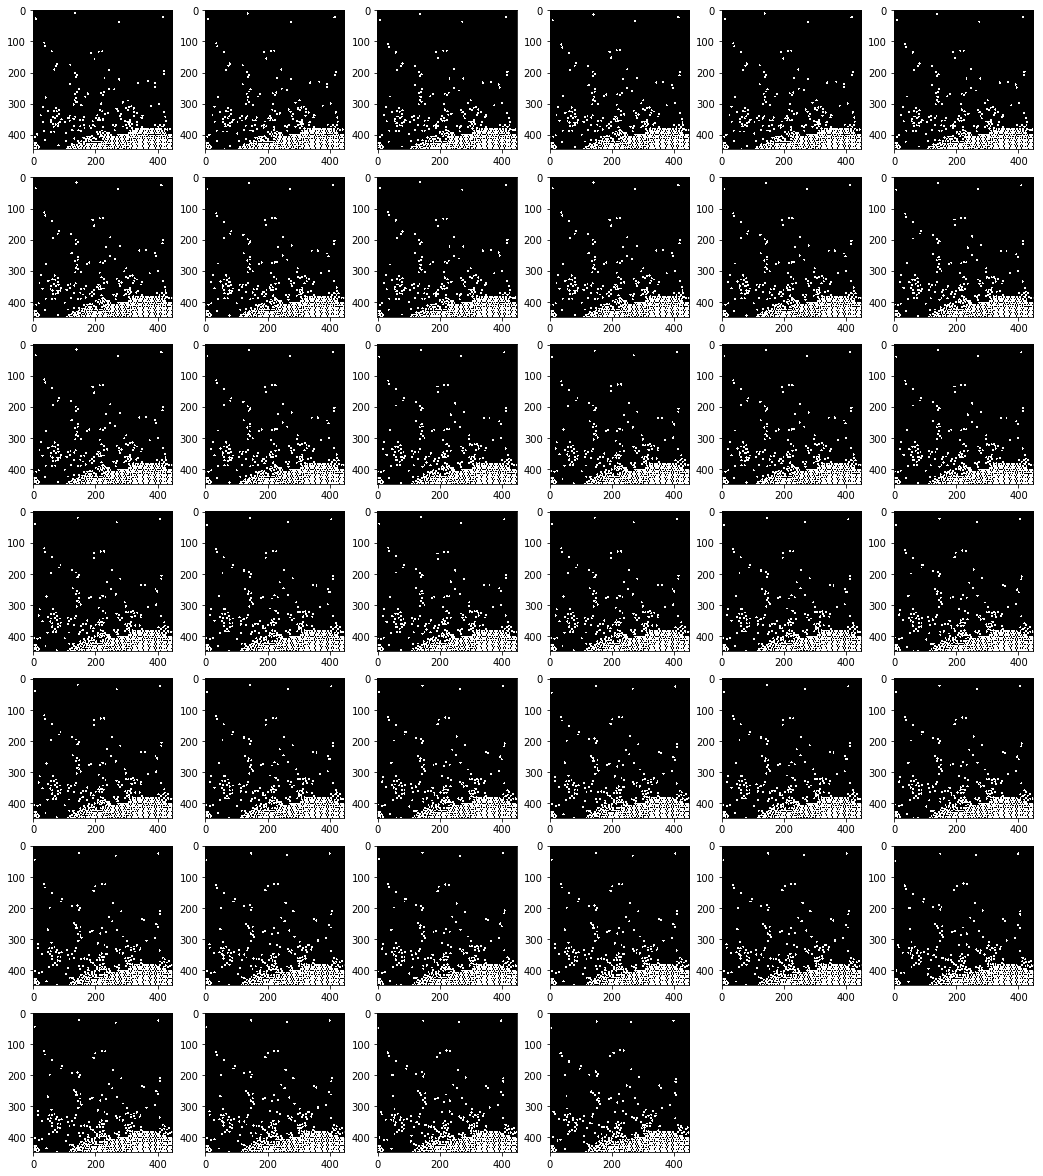

In [9]:
# Plot like text
ncols = 6
nrows = (len(xb) // ncols) + 1
plt.figure(figsize=(3 * ncols, 3 * nrows))
for i in range(len(xb)):
    plt.subplot(nrows, ncols, i + 1)
    if yb.shape[-1] == 1:
        plt.imshow(yb[i, ..., 0], cmap='gray')
    else:
        plt.imshow(yb[i, ..., 1:] * 255)

# Prepare Network for Statefulness

In [10]:
# Replace input layer with one that has batchsize 
new_input = Input(shape=(1, input_height, input_width, input_channels)) # time step of 1
model.layers.pop(0)
new_output = model(new_input)

new_model = Model(new_input, new_output)

In [11]:
# Set all LSTM cells to keep state
for l in new_model.layers:
    if 'lst' in l.name:
        l.stateful = True

# Feed output back as next input while keeping state

In [14]:
# Reset states
new_model.reset_states()

# Feed output back as input
len_init = 3
len_sequence = 20
x = xb[np.newaxis, 0:1, ...]
o = []

# initialize state
for i in range(len_init):
    x = xb[np.newaxis, i:i+1, ...]
    p = new_model.predict(x)
    o.append(p)
    
x = xb[np.newaxis, len_init:len_init+1, ...]
for i in range(len_sequence):
    p = new_model.predict(x)
    o.append(p)
    # continue with last prediction
    x = p

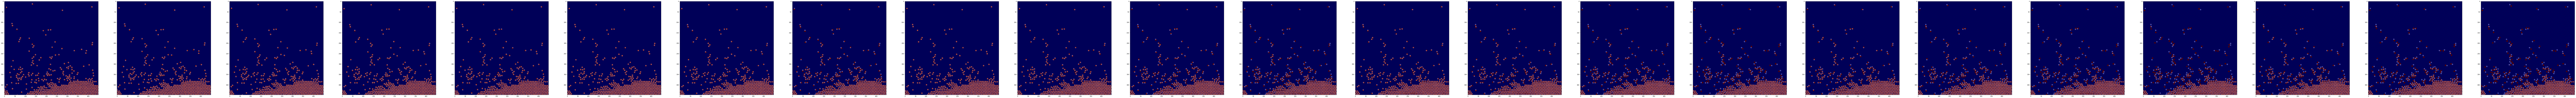

In [15]:
output = np.squeeze(o)

ncols = len(output)
nrows = 1
plt.figure(figsize=(15 * ncols, 15 * nrows))
for i in range(len(output)):
    plt.subplot(nrows, ncols, i + 1)
    if yb.shape[-1] == 1:
        plt.imshow(output[i], cmap='gray', interpolation='none')
        plt.imshow(yb[i, ..., 0], cmap='jet', interpolation='none', alpha=0.7)
    else:        
        plt.imshow(output[i, ..., 1:], cmap='gray', interpolation='none')
        plt.imshow(yb[i, ..., 1:] * 255, cmap='jet', interpolation='none', alpha=0.7)

# Feed one image at a time and compare to target

In [16]:
# Reset states
new_model.reset_states()

# Feed output back as input
len_sequence = 15

o = []
for i in range(len_sequence):
    x = xb[np.newaxis, i:i+1, ...]
    p = new_model.predict(x)
    o.append(p)

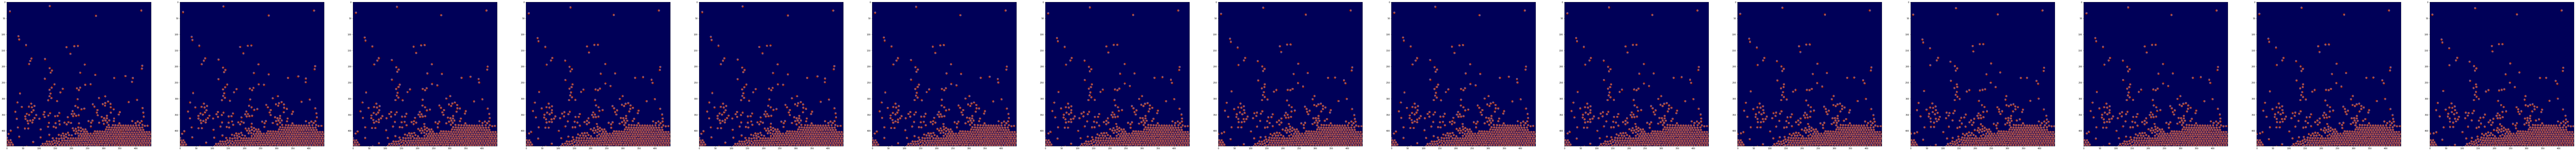

In [17]:
output = np.squeeze(o)

ncols = len(output)
nrows =  1
plt.figure(figsize=(15 * ncols, 15 * nrows))
for i in range(len(output)):
    plt.subplot(nrows, ncols, i + 1)
    if yb.shape[-1] == 1:
        plt.imshow(output[i], cmap='gray', interpolation='none')
        plt.imshow(yb[i, ..., 0], cmap='jet', interpolation='none', alpha=0.7)
    else:        
        plt.imshow(output[i, ..., 1:], cmap='gray', interpolation='none')
        plt.imshow(yb[i, ..., 1:] * 255, cmap='jet', interpolation='none', alpha=0.7)